## Netflix Study Using Kaggle 


### Created by Steven Bowler  see this notebook [here](https://github.com/stevenbowler/netflixstudy/blob/master/notebooks/netflix-movie-recommendation.ipynb), Github project [here](https://github.com/stevenbowler/netflixstudy).
 Attribution: *[DLao - 2020/09 data wrangling](https://www.kaggle.com/stevenbowler/netflix-movie-recommendation/edit)* used loading through mapping steps then output to .csv files, later to be loaded to sql.  Since the dataset has appx 100MM records, can't handle in memory available.


df crashing see error below on pivot. See stackoverflow [solution](https://stackoverflow.com/questions/51202801/is-there-any-way-to-increase-memory-assigned-to-jupyter-notebook).  Recommends following from anaconda shell prompt:

$ jupyter notebook --NotbookApp.iopub_Data_Rate_Limit=1e10

## Table of Contents:

* Objective

* Data manipulation
    -  Data loading
    -  Data viewing
    -  Data cleaning
    -  Data slicing
    -  Data mapping
    -  Output to .CSV files for load to MySQL

* Data profiling
    - Pandas profiling
    - Pandas profiling output [here](https://github.com/stevenbowler/netflixstudy/tree/master/reports)
    
* Recommendation models
    -  Recommend with Collaborative Filtering (*Edit on 2017/11/07*)
    -  Recommend with Pearsons' R correlation

# Objective
Develop a model to predict movie ratings based on the [Netflix Kaggle Dataset](https://www.kaggle.com/netflix-inc/netflix-prize-data)

# Data manipulation

## Data loading

Each data file (there are 4 of them) contains below columns:

* Movie ID (as first line of each new movie record / file)
* Customer ID
* Rating (1 to 5)
* Date they gave the ratings

There is another file contains the mapping of Movie ID to the movie background like name, year of release, etc

Import the library we needed before we get started:

In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# from surprise import Reader, Dataset, SVD
# from surprise.model_selection import cross_validate
sns.set_style("darkgrid")

Load first data file and get a feeling of how huge the dataset is:

In [2]:
# Skip date
df1 = pd.read_csv('../data/raw/combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
# df1 = pd.read_csv('../data/raw/combined_data_test.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

df1['Rating'] = df1['Rating'].astype(float)  # original use float
# df1['Rating'] = df1['Rating'].astype('int8', copy=False) # SB use this down below


print('Dataset 1 shape: {}'.format(df1.shape))
print('-Dataset examples-')
print(df1.iloc[::5000000, :])

Dataset 1 shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


Due to the size of the dataset, handle in 4 parts, output each to .csv (later to be unified/loaded in MySQL):

In [4]:
df2 = pd.read_csv('../data/raw/combined_data_2.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df3 = pd.read_csv('../data/raw/combined_data_3.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df4 = pd.read_csv('../data/raw/combined_data_4.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])


df2['Rating'] = df2['Rating'].astype(float)
df3['Rating'] = df3['Rating'].astype(float)
df4['Rating'] = df4['Rating'].astype(float)

print('Dataset 2 shape: {}'.format(df2.shape))
print('Dataset 3 shape: {}'.format(df3.shape))
print('Dataset 4 shape: {}'.format(df4.shape))

Dataset 2 shape: (26982302, 2)
Dataset 3 shape: (22605786, 2)
Dataset 4 shape: (26851926, 2)


Handle in 4 separate parts, later will be combined when loaded to MySQL

In [5]:
# just do one df at a time, of the four

df = df1
df = df1.append(df2)   # these will not be combined now
df = df.append(df3)
df = df.append(df4)

df.index = np.arange(0,len(df))
print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::5000000, :])

Full dataset shape: (100498277, 2)
-Dataset examples-
           Cust_Id  Rating
0               1:     NaN
5000000    2560324     4.0
10000000   2271935     2.0
15000000   1921803     2.0
20000000   1933327     3.0
25000000   1465002     3.0
30000000    961023     4.0
35000000   1372532     5.0
40000000    854274     5.0
45000000    116334     3.0
50000000    768483     3.0
55000000   1331144     5.0
60000000   1609324     2.0
65000000   1699240     3.0
70000000   1776418     4.0
75000000   1643826     5.0
80000000    932047     4.0
85000000   2292868     4.0
90000000    932191     4.0
95000000   1815101     3.0
100000000   872339     4.0


## Data viewing

Take a first look on how the data spread:

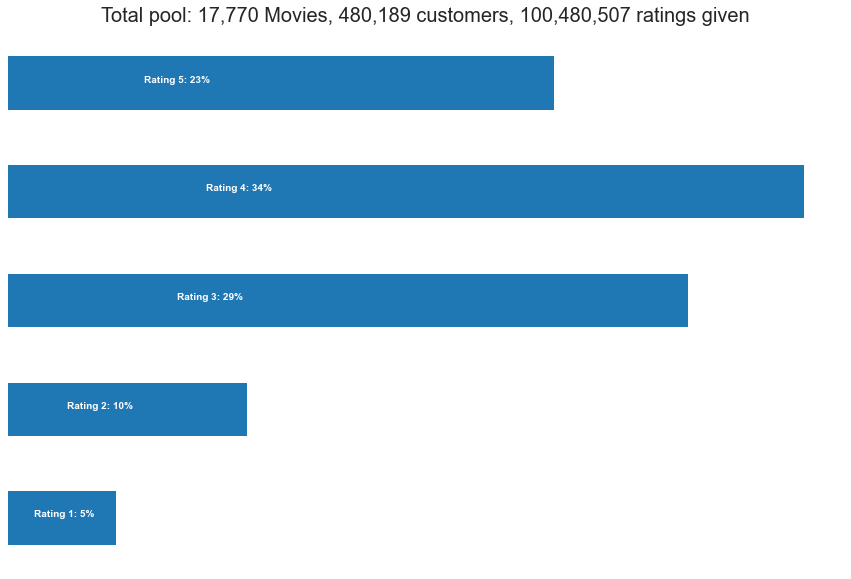

In [6]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df.isnull().sum()[1]

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')



Note that the rating tends to be relatively positive (>3). This may be due to the fact that unhappy customers tend to just leave instead of making efforts to rate. We can keep this in mind - low rating movies mean they are generally really bad

## Data cleaning

Movie ID is really a mess import! Looping through dataframe to add Movie ID column WILL make the Kernel run out of memory as it is too inefficient. I achieve my task by first creating a numpy array with correct length then add the whole array as column into the main dataframe! Let's see how it is done below:

In [7]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 1.777e+04 1.777e+04 1.777e+04]
Length: 100480507


In [8]:
# remove those Movie ID rows
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::5000000, :])


-Dataset examples-
           Cust_Id  Rating  Movie_Id
1          1488844     3.0         1
5000996     501954     2.0       996
10001962    404654     5.0      1962
15002876    886608     2.0      2876
20003825   1193835     2.0      3825
25004661   1899206     3.0      4661
30005496    154804     4.0      5496
35006274   2078749     5.0      6274
40007057    450763     5.0      7057
45007991    102092     3.0      7991
50009023    220298     5.0      9023
55010042    550530     5.0     10042
60011038    222570     3.0     11038
65011875   1273080     5.0     11875
70012676   2026970     5.0     12676
75013582    506044     4.0     13582
80014453    353605     2.0     14453
85015116    664606     3.0     15116
90016008   2213715     3.0     16008
95016879   1589401     5.0     16879
100017627  2314006     4.0     17627


 <font color=red>  added to reduce memory usage

In [8]:
df['Rating'] = df['Rating'].astype('int8', copy=False)


<ipython-input-8-44c5b61e93c1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Rating'] = df['Rating'].astype('int8', copy=False)


In [9]:
df.head()

,Cust_Id,Rating,Movie_Id
1,1488844,3,1
2,822109,5,1
3,885013,4,1
4,30878,4,1
5,823519,3,1


In [10]:
df.dtypes

Cust_Id     int32
Rating       int8
Movie_Id    int32
dtype: object

## Data slicing

The data set now is super huge. Reduce the data volumn by improving the data quality below:

* Remove movie with too few reviews (they are relatively not popular)
* Remove customer who give too few reviews (they are relatively less active)

Having above benchmark will have significant improvement on efficiency, since those unpopular movies and non-active customers still occupy same volumn as those popular movies and active customers in the view of matrix (NaN still occupy space). This should help improve the statistical signifiance too.


In [9]:
f = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 1948.0
Customer minimum times of review: 211.0


Now let's trim down our data, whats the difference in data size?

In [10]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::5000000, :])

Original Shape: (100480507, 3)
After Trim Shape: (71833509, 3)
-Data Examples-
          Cust_Id  Rating  Movie_Id
696        712664     5.0         3
6959351   1973032     4.0      1395
13901827   412139     5.0      2660
20826547  1503396     4.0      3925
27788420  2417320     2.0      5121
34830730  2551271     5.0      6240
41872703  2406150     4.0      7399
48692662  1305391     2.0      8782
55551262   528496     3.0     10158
62650465   599678     2.0     11376
69655550   964493     5.0     12612
76741354   829466     5.0     13923
83765399  2255251     4.0     14953
90860581  1097827     4.0     16169
97938791  1463885     5.0     17321


In [15]:
df.head()
# df.shape

,Cust_Id,Rating,Movie_Id
696,712664,5.0,3
697,1331154,4.0,3
698,2632461,3.0,3
699,44937,5.0,3
700,656399,4.0,3


Save the clean df dataframe for later ... EDA, testing/loading to SQL etc

In [14]:
df.to_csv('../data/processed/df.csv')

Let's pivot the data set and put it into a giant matrix - we need it for our recommendation system:

In [1]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')

print(df_p.shape)

# Below is another way I used to sparse the dataframe...doesn't seem to work better

#Cust_Id_u = list(sorted(df['Cust_Id'].unique()))
#Movie_Id_u = list(sorted(df['Movie_Id'].unique()))
#data = df['Rating'].tolist()
#row = df['Cust_Id'].astype('category', categories=Cust_Id_u).cat.codes
#col = df['Movie_Id'].astype('category', categories=Movie_Id_u).cat.codes
#sparse_matrix = csr_matrix((data, (row, col)), shape=(len(Cust_Id_u), len(Movie_Id_u)))
#df_p = pd.DataFrame(sparse_matrix.todense(), index=Cust_Id_u, columns=Movie_Id_u)
#df_p = df_p.replace(0, np.NaN)


NameError: name 'pd' is not defined

In [18]:
df_p.head()

Movie_Id,28,30,58,77,83,108,111,118,143,148,...,4384,4389,4392,4393,4402,4418,4432,4472,4479,4488
Cust_Id,,,,,,,,,,,,,,,,,,,,,
6,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,3.0,3.0,NaN,NaN
7,4.0,5.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,4.0,NaN,NaN,5.0,3.0,5.0,NaN
79,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,NaN
134,5.0,NaN,5.0,4.0,NaN,NaN,NaN,5.0,5.0,5.0,...,4.0,5.0,NaN,5.0,NaN,5.0,5.0,NaN,NaN,NaN
199,NaN,5.0,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,5.0,NaN,NaN,NaN


In [ ]:
df_p.dtypes

In [ ]:
df_test = df_p

In [ ]:
df_test = df_test.astype('Int8')

In [ ]:
df_test.head()

In [ ]:
df_test.info()

In [ ]:
df_test.describe()

In [ ]:
df_isna_mask = df_test.isna()

In [ ]:
df_isna_mask.head()

In [ ]:
df_test.head()

In [ ]:
df_test.fillna(0, inplace = True)

In [ ]:
df_test_NaN = df_test.replace(0,pd.NA)

In [ ]:
df_test_NaN.head()

In [ ]:
df_test_NaN.shape

In [ ]:
df_test_NaN_short = df_test_NaN[0:100]

In [ ]:
df_test_NaN_short.head()

In [ ]:
df_test_NaN_short.shape

In [ ]:
df_test.head()

In [ ]:
df_test_NaN.convert_dtypes()

In [ ]:
df_p.head(200)

In [ ]:
df_p_short = df_p[0:10]

In [ ]:
df_p_short.head()

## Data profiling with Pandas profiler (Steven Bowler)

In [19]:
# df_p_profile = ProfileReport(df_p, title='Pandas Profiling Report',correlations={"cramers": {"calculate": False},"pearson": {"calculate": False},"spearman": {"calculate": False},"kendall": {"calculate": False},"phi_k": {"calculate": False}})
df_p_profile = ProfileReport(df_p, title='Pandas Profiling Report',correlations=None)

In [ ]:
df_p_profile.to_file('../data/raw/df_p_profile.html') # '../data/raw/df_p_profile.html'

In [19]:
df_p_profile.to_widgets()

## Data mapping

Now we load the movie mapping file:

In [ ]:
df_title = pd.read_csv('../data/raw/movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
print (df_title.head(10))

# Recommendation models

Well all data required is loaded and cleaned! Next let's get into the recommendation system.

## Recommend with Collaborative Filtering

Evalute performance of [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering), with just first 100K rows for faster process:

In [ ]:
reader = Reader()

# get just top 100K rows for faster run time
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:], reader)
#data.split(n_folds=3)

svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

Below is what user 783514 liked in the past:

In [ ]:
df_785314 = df[(df['Cust_Id'] == 785314) & (df['Rating'] == 5)]
df_785314 = df_785314.set_index('Movie_Id')
df_785314 = df_785314.join(df_title)['Name']
print(df_785314)


Let's predict which movies user 785314 would love to watch:

In [ ]:
user_785314 = df_title.copy()
user_785314 = user_785314.reset_index()
user_785314 = user_785314[~user_785314['Movie_Id'].isin(drop_movie_list)]

# getting full dataset
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)

trainset = data.build_full_trainset()
svd.fit(trainset)

user_785314['Estimate_Score'] = user_785314['Movie_Id'].apply(lambda x: svd.predict(785314, x).est)

user_785314 = user_785314.drop('Movie_Id', axis = 1)

user_785314 = user_785314.sort_values('Estimate_Score', ascending=False)
print(user_785314.head(10))

## Recommend with Pearsons' R correlations

The way it works is we use Pearsons' R correlation to measure the linear correlation between review scores of all pairs of movies, then we provide the top 10 movies with highest correlations:

In [ ]:
def recommend(movie_title, min_count):
    print("For movie ({})".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    i = int(df_title.index[df_title['Name'] == movie_title][0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
    print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))

A recommendation for you if you like 'What the #$*! Do We Know!?'

In [ ]:
recommend("What the #$*! Do We Know!?", 0)

X2: X-Men United:

In [ ]:
recommend("X2: X-Men United", 0)

Hope it is a good read. I will keep updating this Kernel (more models etc). Welcome any suggestions!
